# PROJECT NAME : Inflation Rate Using Time-series - INDIA
# Data collected from International Monetary Fund 
# (Inflation rate, average consumer prices)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import klib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('indianinflationdata.csv')

In [3]:
df1=df.T
df1.head()

,0
1960,1.779878
1961,1.695213
1962,3.632215
1963,2.946161
1964,13.355261


In [4]:
df1.columns =["cpi"]
df1

,cpi
1960,1.779878
1961,1.695213
1962,3.632215
1963,2.946161
1964,13.355261
...,...
2016,4.948216
2017,3.328173
2018,3.945069
2019,3.723276


# EDA

In [5]:
df1.isnull().sum()

cpi    0
dtype: int64

In [6]:
df1.duplicated().sum()

0

In [7]:
df1.describe()

,cpi
count,61.000000
mean,7.425945
std,4.950470
min,-7.633948
25%,4.009436
50%,6.649500
75%,10.224886
max,28.598734


<AxesSubplot:>

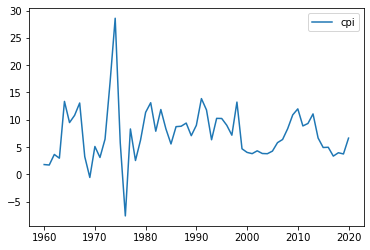

In [8]:
df1.plot()

{'whiskers': [<matplotlib.lines.Line2D at 0x2cae7b5f9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x2cae7b6f130>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cae7b5f640>],
 'medians': [<matplotlib.lines.Line2D at 0x2cae7b6f850>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cae7b6fbe0>],
 'means': []}

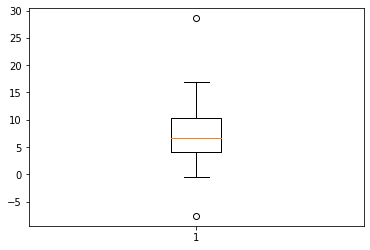

In [9]:
plt.boxplot(df1['cpi'])

In [10]:
#convert into datetime
df1.index = pd.to_datetime(df1.index)

In [11]:
df1.index.names = ['year']

In [12]:
df1.describe()

,cpi
count,61.000000
mean,7.425945
std,4.950470
min,-7.633948
25%,4.009436
50%,6.649500
75%,10.224886
max,28.598734


# Upsampling year to month 

In [13]:
upsampled = df1.resample('MS')
final = upsampled.interpolate(method='linear')
final.head()

,cpi
year,
1960-01-01,1.779878
1960-02-01,1.772822
1960-03-01,1.765767
1960-04-01,1.758712
1960-05-01,1.751656


In [14]:
final.to_csv('final.csv', header=True)

In [15]:
#12 months 
final['2019'].head()

,cpi
year,
2019-01-01,3.723276
2019-02-01,3.964957
2019-03-01,4.206637
2019-04-01,4.448317
2019-05-01,4.689997


In [16]:
final.describe()

,cpi
count,721.000000
mean,7.475137
std,4.359128
min,-7.633948
25%,4.124532
50%,7.548518
75%,10.078476
max,28.598734


# Visualization

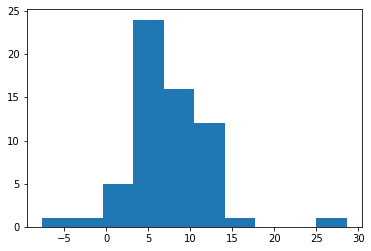

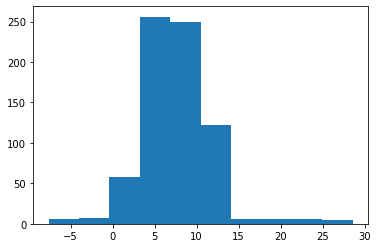

In [17]:
from matplotlib import pyplot
#Histogram of original data
pyplot.hist(df1['cpi'])
pyplot.show()
#Histogram of upsampled data
pyplot.hist(final['cpi'])
pyplot.show()

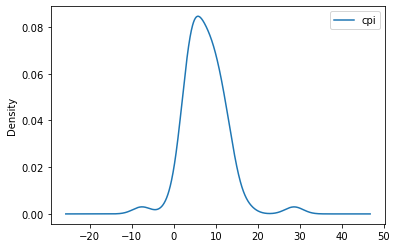

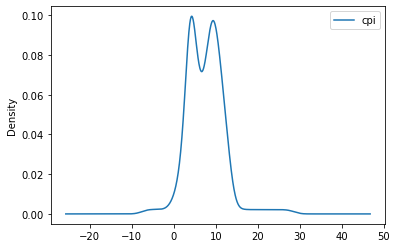

In [18]:
#Density Plot of original data
df1.plot(kind='kde')
pyplot.show()
#Density plot of upsampled data
final.plot(kind='kde')
pyplot.show()

<AxesSubplot:xlabel='cpi', ylabel='Density'>

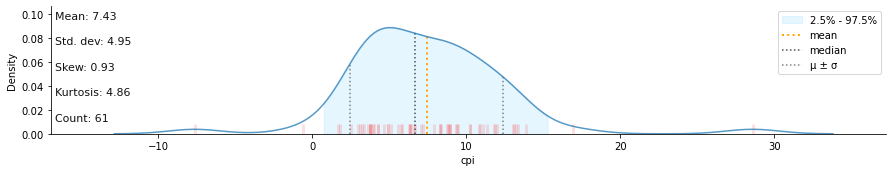

In [19]:
klib.dist_plot(df1)

<AxesSubplot:xlabel='cpi', ylabel='Density'>

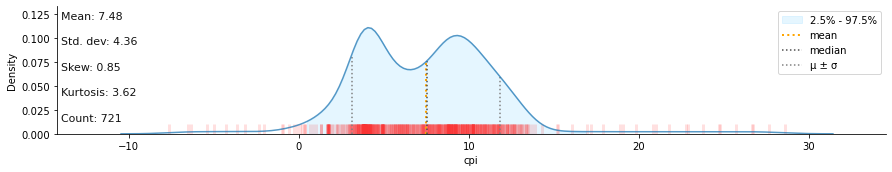

In [20]:
klib.dist_plot(final)

# Time series decomposition plot


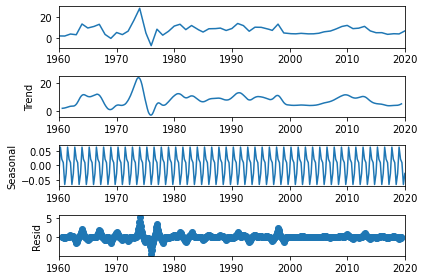

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(final,period=15)
decompose_ts_add.plot()
plt.show()

# Testing for stationary

In [22]:
#Determine rolling statistics
rolmean =final.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = final.rolling(window=12).std()

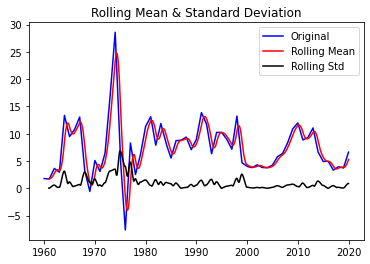

In [23]:
#Plot rolling statistics
orig = plt.plot(final, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# adfuller test

In [24]:
from statsmodels.tsa.stattools import adfuller
X=final['cpi'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -5.527208
p-value: 0.000002
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Reject Ho - Time Series is Stationary


In [25]:
from statsmodels.tsa.stattools import adfuller
adfuller_test=adfuller(final)
print("pvalue :",adfuller_test[1])

pvalue : 1.8213376395622163e-06


# ACF plots and PACF plots

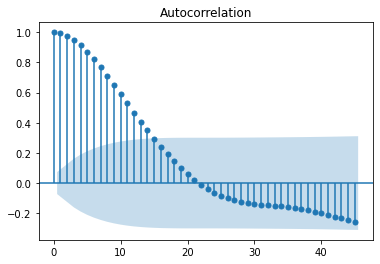

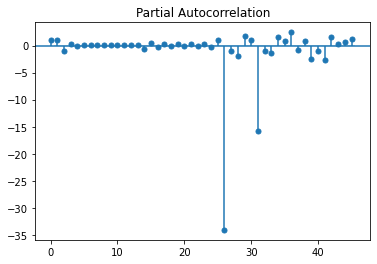

In [26]:
#ACF Plot & PACF Plot
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(final,lags=45)
tsa_plots.plot_pacf(final,lags=45)
plt.show()

In [27]:
final.shape

(721, 1)

In [28]:
# separate out a validation dataset
split_point = len(final) - 100
dataset, validation = final[0:split_point], final[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 621, Validation 100


In [29]:
print(final.shape)
train=final.iloc[:-100]
test=final.iloc[-100:]
print(train.shape,test.shape)

(721, 1)
(621, 1) (100, 1)


# Holt method

year
1960-01-01          NaN
1960-02-01     1.772509
1960-03-01     1.765767
1960-04-01     1.758712
1960-05-01     1.751656
                ...    
2019-09-01    12.793761
2019-10-01    12.831602
2019-11-01    12.869442
2019-12-01    12.907282
2020-01-01    12.945123
Freq: MS, Length: 721, dtype: float64
2.334502820854231


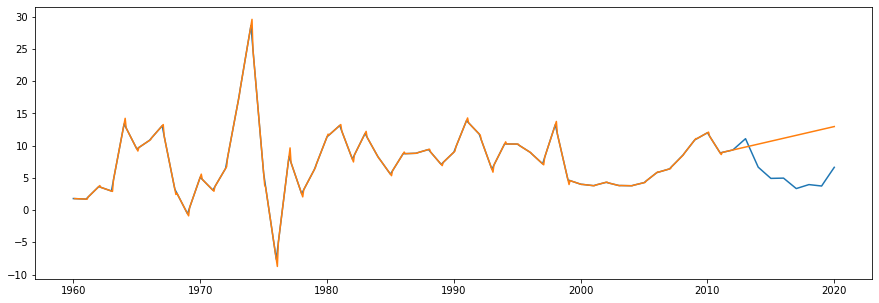

In [30]:
# Holt method
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing 
from sklearn.metrics import mean_squared_error
hw_model = Holt(train).fit()
pred_hw = hw_model.predict(1,721)
prediction_series = pd.Series(pred_hw,index = final.index)
print(prediction_series)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(final['cpi'])
plt.plot(prediction_series)
rmse1 = np.sqrt(mean_squared_error(final,pred_hw))
print(rmse1)

# Exponential Smoothing

2.334502820854231
year
1960-01-01          NaN
1960-02-01     1.772509
1960-03-01     1.765767
1960-04-01     1.758712
1960-05-01     1.751656
                ...    
2019-09-01    12.793761
2019-10-01    12.831602
2019-11-01    12.869442
2019-12-01    12.907282
2020-01-01    12.945123
Freq: MS, Length: 721, dtype: float64


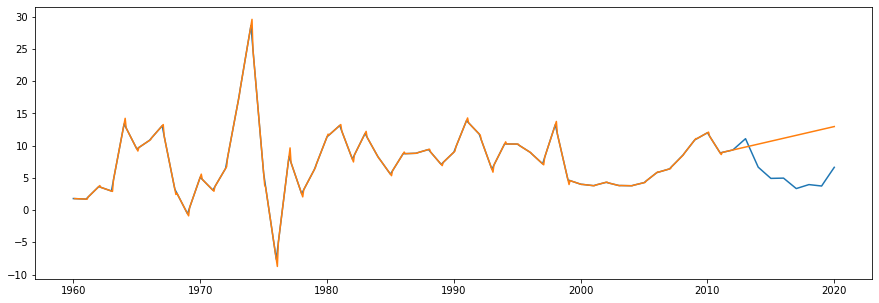

In [31]:
#Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#Exponential Smoothing with Additive trend
exp_add = ExponentialSmoothing(train,trend = 'add').fit()
prediction = exp_add.predict(1,721)
rmse2 = np.sqrt(mean_squared_error(final['cpi'],prediction))
print(rmse2)
prediction_series = pd.Series(prediction,index = final.index)
print(prediction_series)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(final['cpi'])
plt.plot(prediction_series)

# Simple Exponential Method

year
1960-01-01         NaN
1960-02-01    1.791923
1960-03-01    1.788103
1960-04-01    1.783636
1960-05-01    1.778651
                ...   
2019-09-01    9.193565
2019-10-01    9.193565
2019-11-01    9.193565
2019-12-01    9.193565
2020-01-01    9.193565
Freq: MS, Length: 721, dtype: float64
2.0789040313479714


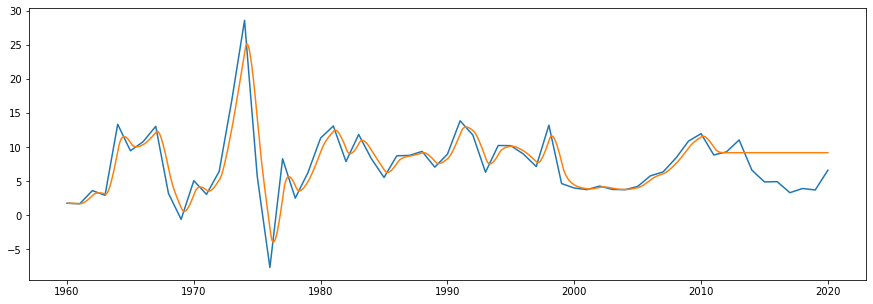

In [32]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(1,721)

prediction_series = pd.Series(pred_ses,index = final.index)
print(prediction_series)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(final['cpi'])
plt.plot(prediction_series)
rmse3 = np.sqrt(mean_squared_error(final,pred_ses))
print(rmse3)

# Base model

In [33]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [34]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=7.936, Expected=8.201
>Predicted=8.201, Expected=8.465
>Predicted=8.465, Expected=8.730
>Predicted=8.730, Expected=8.736
>Predicted=8.736, Expected=8.742
>Predicted=8.742, Expected=8.748
>Predicted=8.748, Expected=8.754
>Predicted=8.754, Expected=8.759
>Predicted=8.759, Expected=8.765
>Predicted=8.765, Expected=8.771
>Predicted=8.771, Expected=8.777
>Predicted=8.777, Expected=8.783
>Predicted=8.783, Expected=8.789
>Predicted=8.789, Expected=8.795
>Predicted=8.795, Expected=8.801
>Predicted=8.801, Expected=8.850
>Predicted=8.850, Expected=8.898
>Predicted=8.898, Expected=8.947
>Predicted=8.947, Expected=8.995
>Predicted=8.995, Expected=9.044
>Predicted=9.044, Expected=9.092
>Predicted=9.092, Expected=9.141
>Predicted=9.141, Expected=9.189
>Predicted=9.189, Expected=9.238
>Predicted=9.238, Expected=9.286
>Predicted=9.286, Expected=9.335
>Predicted=9.335, Expected=9.383
>Predicted=9.383, Expected=9.191
>Predicted=9.191, Expected=8.999
>Predicted=8.999, Expected=8.806
>Predicted

# ARIMA

In [35]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Grid search for p,d,q values

In [36]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [37]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
#evaluate parameters
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

#Best ARIMA(2, 0, 1) RMSE=0.111

ARIMA(0, 0, 0) RMSE=2.788
ARIMA(0, 0, 1) RMSE=1.396
ARIMA(0, 1, 0) RMSE=0.246
ARIMA(0, 1, 1) RMSE=0.164
ARIMA(0, 1, 2) RMSE=0.138
ARIMA(1, 0, 0) RMSE=0.246
ARIMA(1, 0, 1) RMSE=0.164
ARIMA(1, 0, 2) RMSE=0.138
ARIMA(1, 1, 0) RMSE=0.112
ARIMA(1, 1, 1) RMSE=0.111
ARIMA(1, 1, 2) RMSE=0.111
ARIMA(2, 0, 1) RMSE=0.111
ARIMA(2, 0, 2) RMSE=0.111
ARIMA(2, 1, 0) RMSE=0.111
ARIMA(2, 1, 1) RMSE=0.112
ARIMA(2, 1, 2) RMSE=0.112
Best ARIMA(2, 0, 1) RMSE=0.111


In [38]:
rmse_df = pd.DataFrame({'Model':['ARIMA','Holt method','ExponentialSmoothing_add','Simple Exponential'],'RMSE':[0.11,rmse1,rmse2,rmse3]})
rmse_df

,Model,RMSE
0,ARIMA,0.110000
1,Holt method,2.334503
2,ExponentialSmoothing_add,2.334503
3,Simple Exponential,2.078904


# Build Model based on the optimized values

In [39]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [40]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

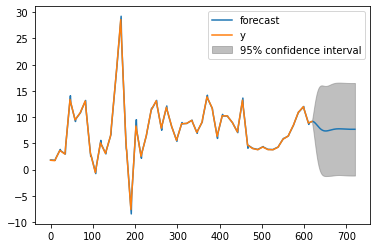

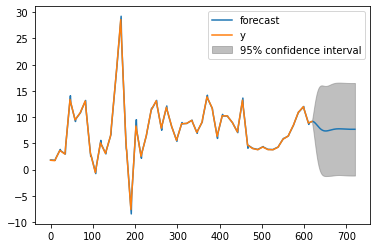

In [41]:
# fit model
model = ARIMA(X, order=(2,0,1))
model_fit = model.fit()
forecast=model_fit.forecast(steps=100)[0]
model_fit.plot_predict(1, 721)

In [42]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = np.sqrt(mean_squared_error(val[1], forecast))
rmse

2.8422615170068766

# Combine train and test data and build final model

In [43]:
# prepare data
X = final.values
X = X.astype('float32')

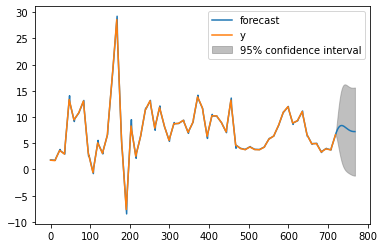

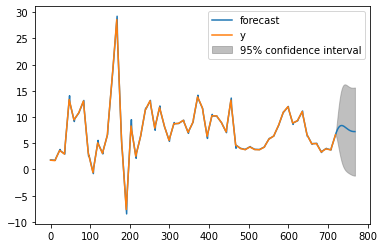

In [44]:
# fit model
model = ARIMA(X, order=(2,0,1))
model_fit = model.fit()
forecast=model_fit.forecast(steps=48)[0]
model_fit.plot_predict(1, 769)

In [45]:
# Result of next 48 months

In [46]:
forecast

array([6.85239133, 7.06731079, 7.26706648, 7.45079956, 7.61790647,
       7.76802274, 7.90100556, 8.01691542, 8.11599722, 8.19866097,
       8.26546238, 8.31708361, 8.35431433, 8.37803327, 8.38919045,
       8.38879023, 8.37787524, 8.35751138, 8.32877384, 8.29273433,
       8.25044949, 8.20295047, 8.15123377, 8.09625328, 8.03891347,
       7.98006382, 7.92049427, 7.86093181, 7.80203806, 7.74440775,
       7.68856816, 7.63497928, 7.58403475, 7.53606348, 7.49133173,
       7.45004587, 7.41235539, 7.37835638, 7.34809526, 7.32157272,
       7.29874782, 7.27954218, 7.26384423, 7.25151341, 7.24238436,
       7.23627098, 7.23297033, 7.23226645])